## CriticalPath analysis

This notebook provides an example of a simulation that takes a number of __sub_processes__, grouped in a __SequentialActivity__, that is executed in a __WhileActivity__ while a __stop condition__ is not yet met.

For this example we work with the following __sub_processes__:
* sailing empty
* loading
* sailing full
* unloading

After the simulation is run a gantt chart with the critical path is visualised. Note that the simulation is run with an environment within OpenClSim (which is designed for the purpose of extracting the critical path) and not with simpy.Environment.

#### 0. Import libraries

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
from openclsim.critical_path.dependencies_from_simpy_step import DependenciesFromSimpy, CriticalPathEnvironment

#### 1. Initialise simpy environment

In [2]:
# setup environment
my_env = CriticalPathEnvironment(initial_time=0)

#### 2. Define object classes

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {},
)

#### 3. Create objects
##### 3.1. Create site object(s)

In [4]:
# prepare input data for from_site
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "capacity": 100,
                  "level": 100
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

# prepare input data for to_site
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "capacity": 100,
                "level": 0
               }
# instantiate to_site 
to_site = Site(**data_to_site)

##### 3.2. Create vessel object(s)

In [5]:
# prepare input data for vessel_01
data_vessel01 = {"env": my_env,
                 "name": "vessel01",
                 "geometry": location_from_site, 
                 "loading_rate": 0.0004,
                 "unloading_rate": 0.0004,
                 "capacity": 4,
                 "compute_v": lambda x: 10
               }
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)

##### 3.3 Create activity/activities

In [6]:
# initialise registry
registry = {}

In [7]:
# create a list of the sub processes
sub_processes = [
    model.MoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=vessel01,
        destination=from_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="loading",
        registry=registry,
        processor=vessel01,
        origin=from_site,
        destination=vessel01,
        amount=4,
        duration=1000,
    ),
    model.MoveActivity(
        env=my_env,
        name="sailing full",
        registry=registry,
        mover=vessel01,
        destination=to_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading",
        registry=registry,
        processor=vessel01,
        origin=vessel01,
        destination=to_site,
        amount=4,
        duration=1000,
    ),
    model.BasicActivity(
        env=my_env,
        name="basic activity",
        registry=registry,
        duration=0,
        additional_logs=[vessel01],
    ),
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity = model.SequentialActivity(
        env=my_env,
        name="sequential",
        registry=registry,
        sub_processes=sub_processes,
    )

# create a while activity that executes the 'sequential activity' while the stop condition is not triggered 
while_activity = model.WhileActivity(
    env=my_env,
    name="while",
    registry=registry,
    sub_processes=[sequential_activity],
    condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
)

#### 4. Register processes and run simpy

In [8]:
# initate the simpy processes defined in the 'while activity' and run simpy
model.register_processes([while_activity])
my_env.run()

#### 5. Inspect results
##### 5.1 Inspect logs

In [9]:
plot.get_log_dataframe(vessel01, [while_activity])

,Activity,Timestamp,ActivityState,geometry,container level,type,ref
0,sailing empty,1970-01-01 00:00:00.000000,START,POINT (4.18055556 52.18664444),0.0,NaN,NaN
1,sailing empty,1970-01-01 00:00:00.000000,STOP,POINT (4.18055556 52.18664444),0.0,NaN,NaN
2,loading,1970-01-01 00:00:00.000000,START,POINT (4.18055556 52.18664444),0.0,NaN,NaN
3,loading,1970-01-01 00:16:40.000000,STOP,POINT (4.18055556 52.18664444),4.0,NaN,NaN
4,sailing full,1970-01-01 00:16:40.000000,START,POINT (4.18055556 52.18664444),4.0,NaN,NaN
...,...,...,...,...,...,...,...
245,sailing full,1970-01-02 02:26:38.404972,STOP,POINT (4.25222222 52.11428333),4.0,NaN,NaN
246,unloading,1970-01-02 02:26:38.404972,START,POINT (4.25222222 52.11428333),4.0,NaN,NaN
247,unloading,1970-01-02 02:43:18.404972,STOP,POINT (4.25222222 52.11428333),0.0,NaN,NaN
248,basic activity,1970-01-02 02:43:18.404972,START,POINT (4.25222222 52.11428333),0.0,additional log,d8880d11-194b-40f0-8a1d-9bccf5a5738d


##### 5.2 Visualise gantt charts

In [10]:
plot.get_gantt_chart([while_activity])

In [11]:
plot.get_gantt_chart([vessel01, from_site, to_site],id_map=[while_activity])

##### 5.3 Visualise container volume developments

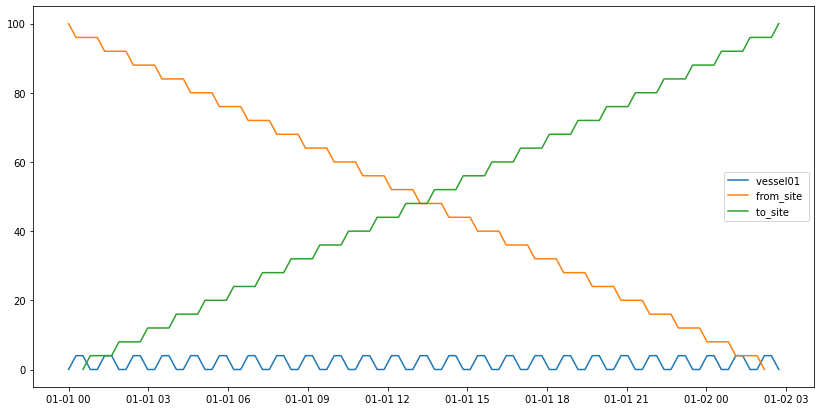

In [12]:
fig = plot.get_step_chart([vessel01, from_site, to_site])

##### 5.4 Visualise critical path

Determine critical path with method 'from simpy'. One can investigate the activities on the critical path through inspection of the dataframe with recorded activities or through a gannt chart.

In [13]:
my_cp_dependencies_from_simpy = DependenciesFromSimpy(env=my_env, 
                                                      object_list=[vessel01, from_site, to_site],
                                                      activity_list=[while_activity])
critical_df = my_cp_dependencies_from_simpy.get_critical_path_df()
print("An overview of recorded activities, with an indication if activity is on critical path (column 'is_critical')")
critical_df

An overview of recorded activities, with an indication if activity is on critical path (column 'is_critical')


,ActivityID,Activity,SimulationObject,start_time,end_time,duration,state,cp_activity_id,is_critical
1,c273fdb9-130b-4b71-a4a4-303b60546d87,loading,from_site,1970-01-01 00:00:00.000000,1970-01-01 00:16:40.000000,0 days 00:16:40,ACTIVE,e9944d13-d1b5-4942-a6ac-644dcf87d172,True
2,c273fdb9-130b-4b71-a4a4-303b60546d87,loading,vessel01,1970-01-01 00:00:00.000000,1970-01-01 00:16:40.000000,0 days 00:16:40,ACTIVE,e9944d13-d1b5-4942-a6ac-644dcf87d172,True
4,13a01de6-d9d2-4f1a-bec2-548554177e35,sailing empty,vessel01,1970-01-01 00:00:00.000000,1970-01-01 00:00:00.000000,0 days 00:00:00,ACTIVE,a9d77903-32e7-44f9-b163-3d999c876bdf,False
11,109d85bb-8f43-4297-9563-7d52da3507a6,sailing full,vessel01,1970-01-01 00:16:40.000000,1970-01-01 00:32:22.824591,0 days 00:15:42.824591,ACTIVE,446dac10-0fc6-426d-8c4b-50f34c5aebfd,True
15,0365fb9b-54f8-49b9-ad7b-2d4c21e25a92,unloading,to_site,1970-01-01 00:32:22.824591,1970-01-01 00:49:02.824591,0 days 00:16:40,ACTIVE,693af218-55bf-4a9e-b3db-4ff1b224abdd,True
...,...,...,...,...,...,...,...,...,...
464,c273fdb9-130b-4b71-a4a4-303b60546d87,loading,vessel01,1970-01-02 01:54:15.580381,1970-01-02 02:10:55.580381,0 days 00:16:40,ACTIVE,a32074c1-a2ff-462e-a781-af13af8b1d1f,True
467,109d85bb-8f43-4297-9563-7d52da3507a6,sailing full,vessel01,1970-01-02 02:10:55.580381,1970-01-02 02:26:38.404972,0 days 00:15:42.824591,ACTIVE,bfb7f285-6818-4b54-a15d-155e5e5b8f00,True
471,0365fb9b-54f8-49b9-ad7b-2d4c21e25a92,unloading,to_site,1970-01-02 02:26:38.404972,1970-01-02 02:43:18.404972,0 days 00:16:40,ACTIVE,099d15f2-cb8f-4c98-a162-47c7165b125e,True
472,0365fb9b-54f8-49b9-ad7b-2d4c21e25a92,unloading,vessel01,1970-01-02 02:26:38.404972,1970-01-02 02:43:18.404972,0 days 00:16:40,ACTIVE,099d15f2-cb8f-4c98-a162-47c7165b125e,True


In [14]:
my_cp_dependencies_from_simpy.make_plotly_gantt_chart()